In [52]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from PIL import Image
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets

In [2]:
class UNet(nn.Module):

    def __init__(self, filters, img_channels=3):
        super(UNet, self).__init__()
        self.up_channels = filters[::-1]
        filters.insert(0, img_channels) # To start from the initial number channels of the image
        self.down_channels = filters
        self.relu = nn.ReLU()
        self.output = nn.Conv2d(filters[1], img_channels, kernel_size=1)
        

    def block_down(self, in_chan, out_chan, kernel_conv=3, pad_conv=1, kernel_pool=2):
        layers = []
        layers.append(nn.Conv2d(in_chan, out_chan, kernel_size=kernel_conv, padding=pad_conv))
        layers.append(nn.Conv2d(out_chan, out_chan, kernel_size=kernel_conv, padding=pad_conv))
        layers.append(nn.MaxPool2d(kernel_size=kernel_pool))
        return layers
    
    def block_up(self, in_chan, out_chan, kernel_conv=3, pad_conv=1, kernel_trans=2, strd_trans=2):
        layers = []
        layers.append(nn.ConvTranspose2d(in_chan, out_chan, kernel_size=kernel_trans, stride=strd_trans))
        layers.append(nn.Conv2d(in_chan, out_chan, kernel_size=kernel_conv, padding=pad_conv))
        layers.append(nn.Conv2d(out_chan, out_chan, kernel_size=kernel_conv, padding=pad_conv))
        return layers

    def forward(self, x):

        # Down block
        x_down = []
        n_dchan = len(self.down_channels)
        for i in range(n_dchan - 1):
            #print(i, 'down')
            in_chan, out_chan = self.down_channels[i], self.down_channels[i + 1]
            #print(in_chan, out_chan) 
            layers = self.block_down(in_chan, out_chan)
            for j in range(2):
                x = self.relu(layers[j](x))    
            x_down.append(x)
            if i != n_dchan - 2: # To avoid maxpooling last block of layers     
                x = layers[-1](x)

        # Up block
        x_down.reverse()
        for i in range(len(self.up_channels) - 1):
            #print(i, 'up')
            in_chan, out_chan = self.up_channels[i], self.up_channels[i + 1] 
            #print(in_chan, out_chan)             
            layers = self.block_up(in_chan, out_chan)
            t_layer = layers[0](x)
            x = torch.concat((t_layer, x_down[i+1]), dim=1)
            for j in range(1, 3):
                x = self.relu(layers[j](x))

        # Output layer        
        x = self.output(x)  # Same size as input image
        return x


(256, 255, 3)


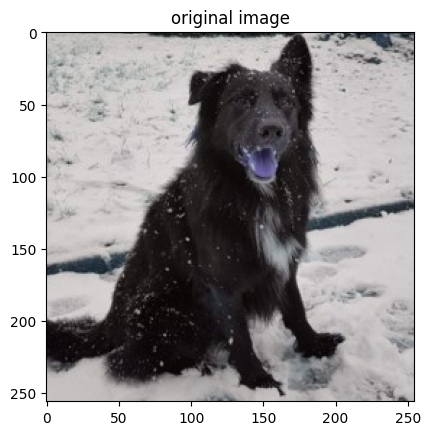

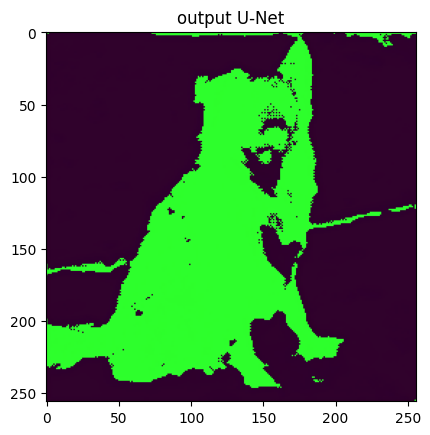

In [48]:
img = cv2.imread('dog.jpg')
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])
img_tensor = transformations(img).unsqueeze(0)

print(img.shape)
plt.title('original image')
plt.imshow(img)
plt.show()


filters = [32, 64, 128]
net = UNet(filters)
pred = net(img_tensor)

def plot_image(tensor):
    img = tensor.reshape(list(tensor.shape[1:])).permute(1, 2, 0)
    img = img.detach().numpy()
    plt.title('output U-Net')
    plt.imshow((img * 255).astype(np.uint8))
    plt.show()

plot_image(pred)


In [133]:
class Difussion:
    def __init__(self, noise_steps=1000, beta_i=1E-4, beta_f=0.02, device='cpu'):
        self.noise_steps = noise_steps
        self.beta_i = beta_i
        self.beta_f = beta_f
        self.device = device

        self.beta = self.noise_scheduler().to(self.device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    # Linear scheduler
    def noise_scheduler(self):
        return torch.linspace(self.beta_i, self.beta_f, self.noise_steps) 

    def forward_diffusion(self, x, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])#[:, None, None, None]
        sqrt_alpha_bar_c = torch.sqrt(1 - self.alpha_bar[t])#[:, None, None, None]
        epsilon = torch.rand_like(x) # Picking a random normalization
        return sqrt_alpha_bar * x + sqrt_alpha_bar_c * epsilon 


In [168]:
IMG_SIZE = 64,
BATCH_SIZE = 1#32

fwd_transformation = transforms.Compose([
        #transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Lambda(lambda t: (t * 2) - 1) # To scale between [-1, 1] 
])

bkd_transformation = transforms.Compose([
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),   
        transforms.Lambda(lambda t: t.numpy()), 
        transforms.Lambda(lambda t: ((t + 1) * 255 * 0.5).astype(np.uint8)),
        transforms.ToPILImage()
])
# Train
train = torchvision.datasets.OxfordIIITPet(root=".", download=True, transform=fwd_transformation)
train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE)
# Test 
test = torchvision.datasets.OxfordIIITPet(root=".", download=True, transform=fwd_transformation, split='test')
test_loader = DataLoader(dataset=test, batch_size=BATCH_SIZE)

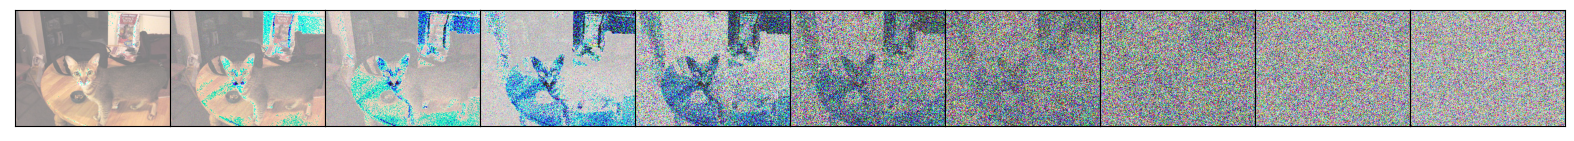

In [170]:
def plot_image_batch(image, n_images=10, T=300):

    step = int(T / n_images)
    plt.figure(figsize=(20, 20)) 
    for t in range(0, T, step):
        plt.subplot(1, n_images, int(t/step) + 1)
        difusion = Difussion(noise_steps=T)
        image = difusion.forward_diffusion(image, t)
        img_reverse = bkd_transformation(image.squeeze(0))
        plt.imshow(img_reverse)
        plt.xticks([])
        plt.yticks([])    
    plt.subplots_adjust(wspace=0, hspace=0)    
    plt.show()
    plt.close()

image = next(iter(test_loader))[0]
plot_image_batch(image)